In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import spikeinterface.full as si
from pathlib import Path
import matplotlib.pyplot as plt
import IO_tools as io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from spikeinterface import __version__ as sivers
print(f'spikeinterface version:  {sivers}')

spikeinterface version:  0.102.3


# batch

## setup

In [ ]:
import os
import torch

batch_drive = Path(r'/mnt/fasthd')  # /mnt/data on docker, /mnt/fasthd on ssd host
batch_folder = batch_drive / '3_TRAP_ISO' / '1_Recordings' 

sessions = {
    'TRP803_R2': {'multiple_shanks': [True, True]},
    # ...
}

global_job_kwargs = dict(n_jobs=0.50, chunk_duration='1s', progress_bar=True)
si.set_global_job_kwargs(**global_job_kwargs)


## run batch





TRP803_R2
('params:\n'
 "{'concatenate': False, 'ksparams': {'batch_size': 45000, 'nblocks': 5, "
 "'Th_universal': 9.0, 'Th_learned': 8.0, 'save_preprocessed_copy': True, "
 "'save_extra_vars': False}}")
	---recording top folder:  "/mnt/data/3_TRAP_ISO/1_Recordings/TRP803/TRP803_R2"
	---saving processed outputs to  "/mnt/data/3_TRAP_ISO/1_Recordings/TRP803/TRP803_R2/2_processed"

Final recording:
	 CompressedBinaryIblExtractor: 384 channels - 29980.050847 Hz - 1 segments - 183,799,868 samples 
                              6,130.74s (1.70 hours) - int16 dtype - 131.46 GiB 


---------Starting sorting---------

...saving sorting output to:
	/mnt/data/3_TRAP_ISO/1_Recordings/TRP803/TRP803_R2/2_processed/kilosort4_byShank_1


100%|██████████| 48/48 [00:25<00:00,  1.87it/s]


Use zarr_path=/mnt/data/3_TRAP_ISO/1_Recordings/TRP803/TRP803_R2/2_processed/kilosort4_byShank_1/aggregated_sorting.zarr


/project/.venv/lib/python3.12/site-packages/spikeinterface/core/basesorting.py:273: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")



---------Sorting finished---------




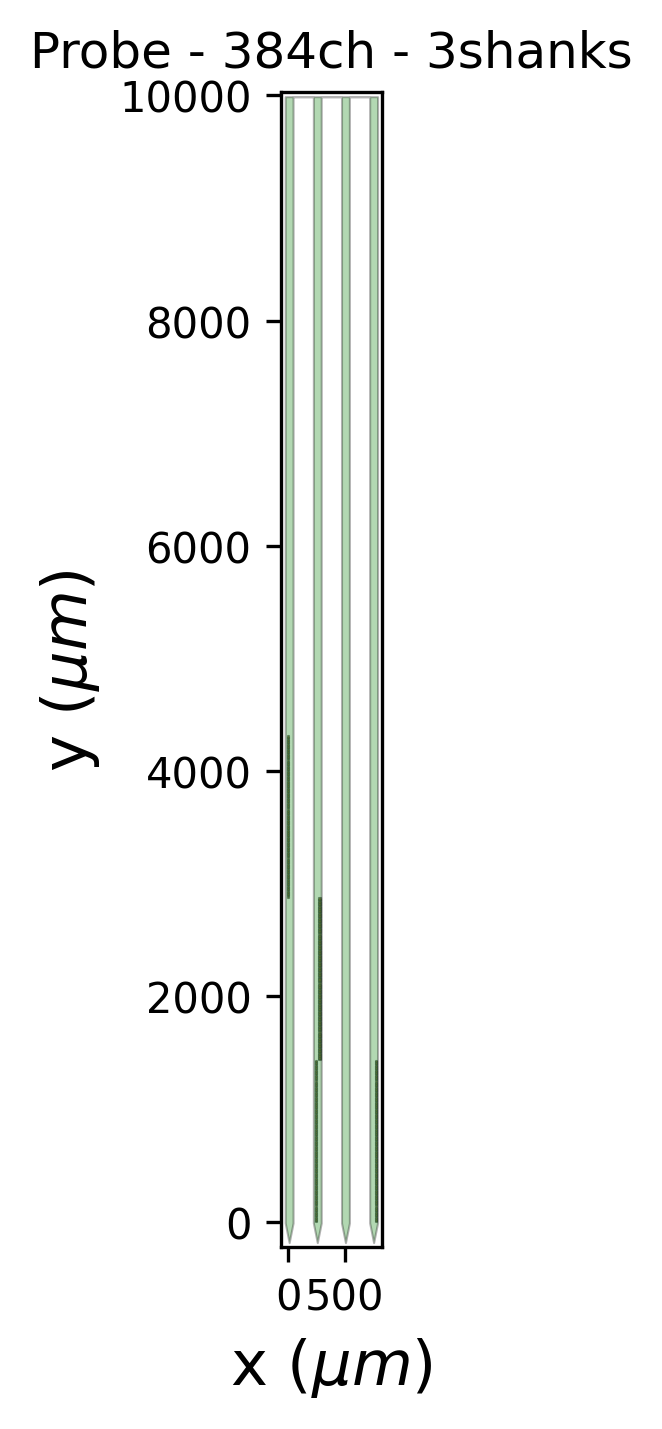

In [ ]:
from probeinterface.plotting import plot_probe, plot_probegroup
from pprint import pprint

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

global_ks_params = dict(
            batch_size=45000, nblocks=5, Th_universal=9.0, Th_learned=8.0,  # 7 and 7?
            save_preprocessed_copy=True, save_extra_vars=False,
        )

default_ks_params = True
for session, session_params in sessions.items():
    if default_ks_params:
        params = dict(
            concatenate=False,
            ksparams=global_ks_params
        )
    else:
        params = sessions_ksparams[session]
    print(f'\n\n\n\n{session}')
    pprint(f'params:\n{params}', indent=2, sort_dicts=False)
    
    animal, rec_num = session.split('_')
    rec_str = f'{animal}_{rec_num}'

    concatenate = params['concatenate']
    ksparams = params['ksparams']

    # compressed version
    raw_folder_name = '0_raw_compressed'
    if not concatenate:
        rec_folder = Path(batch_folder / rf"{animal}/{rec_str}").resolve()
        try:
            # rec_name, _ = io.get_folder_info(rec_folder)
            rec_name = rec_str
        except (AssertionError, OSError):
            rec_folder = Path(batch_folder / rf"{animal}/{rec_str}").resolve()
            rec_name, _ = io.get_folder_info(rec_folder)
    else:
        # multiple recordings
        anim_folder = Path(batch_folder / rf"{animal}").resolve()
        rec_folder = Path(anim_folder / rf"{rec_str}_concat").resolve()
        raw_folder = rec_folder / raw_folder_name
        assert raw_folder.exists(), f'Raw folder not found: {raw_folder}'
        rec_names = [f.name for f in raw_folder.glob(f'{rec_str}*_g*')]

    print(f'\t---recording top folder:  "{rec_folder}"')
    process_folder = rec_folder / '2_processed'
    # process_folder = rec_folder  # if not using the newer folder structure
    assert process_folder.exists(), f'Folder not found: {process_folder}'
    print(f'\t---saving processed outputs to  "{process_folder}"')

    # load recording
    # new structure, raw compressed should be in raw folder
    raw_folder = rec_folder / '0_raw_compressed'
    raw_list = list(raw_folder.rglob('*g0*imec*.cbin'))  # check multiple probes, but not if multiple segments (ie, g0, g1 etc)
    if raw_list==[]:  # if no compressed recordings, get raw recordings
        raw_list = list(raw_folder.rglob('*g0*imec*.bin'))
    # break
    print(f"Found recordings from {len(raw_list)} probes in {raw_folder}:\n\t", *[f.name for f in raw_list], sep='\n\t')

    for probe_num, raw_file in enumerate(raw_list):
        torch.cuda.empty_cache()  # clear GPU memory between probes
        sorter_output_folder = process_folder / f'kilosort4_byShank_{probe_num}'
        if sorter_output_folder.exists():    # skip if folder already exists
            print(f'Skipping probe {probe_num} in {rec_str}, already sorted:  {sorter_output_folder}')
            continue 
        if not concatenate:
            try:
                # rec = si.read_cbin_ibl(next(raw_folder.rglob('*.cbin')).parent, load_sync_channel=False, stream_name='ap')
                rec = si.read_cbin_ibl(cbin_file_path=raw_file, load_sync_channel=False, stream_name='ap')
            except StopIteration:
                rec = si.read_spikeglx(next(raw_folder.rglob('*imec0*')), load_sync_channel=False, stream_id='imec0.ap')
            # rec = read_binary(next(rec_folder.glob('*imec0*')), dtype=np.int16)  # for binary, complicated though
        else:
            rec_files = list(raw_folder.rglob(f'*imec{probe_num}.ap.cbin'))
            print(f'concatenating:\t{rec_files}')
            recs = []
            for i, rec_file in enumerate(rec_files):
                # recs.append(si.read_spikeglx(rec.parent, load_sync_channel=False, stream_id='imec0.ap'))
                recs.append(si.read_cbin_ibl(cbin_file_path=rec_file, load_sync_channel=False, stream_name='ap'))
                print(f'\trec {i}:\t{rec_file}')
            rec = si.concatenate_recordings(recs)
        print('\nFinal recording:\n\t', rec, '\n')

        # save probe channel map plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
        plot_probe(
            rec.get_probe(), 
            ax=ax
        )
        plt.savefig(rec_folder / f'{rec_str}_probe{probe_num}_channel_selection.png', dpi=400, bbox_inches='tight')

        # set sorting parameters
        sorter_params= si.get_default_sorter_params('kilosort4')
        sorter_params.update(ksparams)
        sorter_params.update(dict(fs=rec.get_sampling_frequency()))  # add recording fs to params

        # run sorter
        # multiple_shanks = session_params.get('multiple_shanks', True)  # more likely to be 2.0 4-sh than not
        # if multiple probes then value should be list of true or not for each probe
        # multiple_shanks = multiple_shanks if isinstance(multiple_shanks, bool) else multiple_shanks[probe_num]
        multiple_shanks = True
        if multiple_shanks:
            sorter_output_folder = process_folder / f'kilosort4_byShank_{probe_num}'
            if sorter_output_folder.exists():    # skip if folder already exists
                print(f'Skipping probe {probe_num} in {rec_str}, already sorted:  {sorter_output_folder}')
                continue
            parallel_kwargs = dict(n_jobs=10, chunk_duration='1s', progress_bar=True)
            sorter_params.update(parallel_kwargs)

            print('\n---------Starting sorting---------\n')
            print(f'...saving sorting output to:\n\t{sorter_output_folder}')        
            aggregated_sorting = si.run_sorter_by_property(
                sorter_name='kilosort4',
                recording=rec,
                grouping_property='group',
                folder=sorter_output_folder,
                remove_existing_folder=True,
                docker_image=False,
                # engine='joblib',
                # engine_kwargs=parallel_kwargs,
                **sorter_params
            )
            # concatenate sortings into one folder for postprocessing
            try:
                aggregated_sorting.save_to_zarr(sorter_output_folder / 'aggregated_sorting', overwrite=True, **global_job_kwargs)
            except:
                aggregated_sorting.save_to_zarr(sorter_output_folder / 'aggregated_sorting', overwrite=True)
            print('\n---------Sorting finished---------\n\n')
        else:  # single shank
            sorter_output_folder = process_folder / 'kilosort4'

            print('\n---------Starting sorting---------\n')
            print(f'...saving sorting output to:\n\t{sorter_output_folder}')
            sorting = si.run_sorter(
                sorter_name='kilosort4',
                recording=rec,
                folder=sorter_output_folder,
                remove_existing_folder=True,
                docker_image=False,
                verbose=True,
                **sorter_params,
            )
            # save separate sorting object for postprocessing
            sorting.save_to_zarr(sorter_output_folder / 'sorting', overwrite=True)
            print('\n---------Sorting finished---------\n\n')